In [1]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn import model_selection
from sklearn import preprocessing
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn_pandas import gen_features
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from time import time
from scipy.stats import randint as sp_randint
from scipy.stats import spearmanr
import numpy as np

In [2]:
regr = MLPRegressor(hidden_layer_sizes=(10,10,), random_state = 0, max_iter = 1000) #  MLP is sensitivite to feature scaling but we standardize data so we are fine.
lr = LinearRegression()

In [3]:
scores = pd.read_csv('soretdScores.csv', lineterminator='\n')

In [4]:
data = pd.read_csv('motionData.csv', lineterminator='\n')
data.rename(columns={"FFPType\r": "FFPType"},inplace=True)

In [5]:
FEATURES = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"]
FEATURESALL = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType"]

In [6]:
EMOSCORES = ["happier_mu", "sadder_mu", "angrier_mu"]
EMOCONFIDENCE_INV = ["happier_sigma", "sadder_sigma", "angrier_sigma"]
min_confidence = 25/3 # true skill base confidence: http://trueskill.org/
EMOWTS = ["happier_wt", "sadder_wt", "angrier_wt"]

In [7]:
emotionid = 1;

In [8]:
mapper = DataFrameMapper([
...     (["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"], preprocessing.StandardScaler()),
...     (['FFPType'], preprocessing.OneHotEncoder())], input_df = True, sparse = True)

In [9]:
transformedData = mapper.fit_transform(data.copy())

In [10]:
WTS= {'happier_wt':(1.5-(scores[EMOCONFIDENCE_INV[0]]/min_confidence)).values,
                   'sadder_wt':(1.5-(scores[EMOCONFIDENCE_INV[1]]/min_confidence)).values,
                'angrier_wt':(1.5-(scores[EMOCONFIDENCE_INV[2]]/min_confidence)).values}
WTS_df = pd.DataFrame(WTS,scores.index)
scores_WTS = pd.concat([scores, WTS_df], axis = 1)

In [11]:
 X_train, X_test, y_train, y_test = model_selection.train_test_split(transformedData, scores_WTS, test_size=0.2, random_state=42)

In [12]:
# specify parameters and distributions to sample from
param_dist = {"activation": ["logistic", "tanh", "relu"],
              "learning_rate": ["constant", "invscaling", "adaptive"],
              "solver": ["lbfgs", "sgd", "adam"],
              "alpha" : np.random.uniform(0.0001, 0.01,1),
              "learning_rate_init" : np.random.uniform(0.0001, 0.01,1),
              "momentum": np.random.uniform(0.5, 1,1),
              "early_stopping" : [True, False]}

# run randomized search
n_iter_search = 50
random_search = RandomizedSearchCV(regr, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=-1, cv =10, random_state = 0)

start = time()
random_search.fit(X_train, y_train[EMOSCORES[emotionid]])#, sample_weight=y_train[EMOWTS[emotionid]])
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
print(random_search.cv_results_)

RandomizedSearchCV took 5073.85 seconds for 50 candidates parameter settings.
{'mean_test_score': array([  0.32638104,  -0.30028196,  -0.11501669,  -0.26683832,
        -0.89625632,  -0.90220005,  -0.26159034,  -0.11501669,
        -0.11501669,  -0.30028196, -10.38342553,   0.37566158,
         0.18694188,  -8.0413151 ,  -8.32714056,   0.20712176,
         0.3040272 ,   0.32870939,  -0.89625632,  -0.30028196,
        -0.26159034,  -1.80230223,  -0.30028196,  -0.11501669,
         0.18126672,  -0.28756779,  -0.90220005,  -0.26159034,
         0.3766723 ,   0.36343636,  -0.26683832,   0.3656019 ,
        -0.90220005, -10.59188501,   0.30442412,  -0.89625632,
        -1.49898548,   0.31705597,   0.30221937,  -0.28756779,
         0.20712176,  -0.30028196,  -0.28756779,  -0.26683832,
        -0.11501669,  -0.30028196,   0.30464552,  -0.28756779,
        -0.11501669,   0.32638104]), 'split0_test_score': array([ 0.52043704,  0.27816271,  0.05498792, -0.12642435, -0.57585281,
       -0.572961

C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [13]:
random_search.best_estimator_ 

MLPRegressor(activation='logistic', alpha=0.0052264395675270551,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(10, 10),
       learning_rate='adaptive', learning_rate_init=0.00064200128281687615,
       max_iter=1000, momentum=0.85153716730341489,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [14]:
random_search.best_score_

0.37667229522686863

In [15]:
ytest_pred_Randcv=random_search.best_estimator_.predict(X_test)
ytrain_pred_Randcv=random_search.best_estimator_.predict(X_train)

In [16]:
random_search.best_params_

{'activation': 'logistic',
 'alpha': 0.0052264395675270551,
 'early_stopping': False,
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.00064200128281687615,
 'momentum': 0.85153716730341489,
 'solver': 'sgd'}

In [17]:
random_search.best_estimator_.loss_

10.252919512766493

In [18]:
print("Mean squared error wtd random cv (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred_Randcv,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd random cv (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred_Randcv,sample_weight=y_test[EMOWTS[emotionid]]))
rho, pval = spearmanr(y_test[EMOSCORES[emotionid]],ytest_pred_Randcv)
print('Spearman random cv (test)-- rho: %.4f' % rho, 'p-val: %.20f' % pval)

Mean squared error wtd random cv (test): 27.44
Variance score wtd random cv (test): 0.3637
Spearman random cv (test)-- rho: 0.5748 p-val: 0.00000000000037851953


In [19]:
print("Mean squared error wtd (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred_Randcv,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred_Randcv,sample_weight=y_train[EMOWTS[emotionid]]))
rho, pval = spearmanr(y_train[EMOSCORES[emotionid]],ytrain_pred_Randcv)
print('Spearman random cv (train)-- rho: %.4f' % rho, 'p-val: %.20f' % pval)

Mean squared error wtd (train): 20.45
Variance score wtd (train): 0.49
Spearman random cv (train)-- rho: 0.6663 p-val: 0.00000000000000000000


In [20]:
# use a full grid over all parameters
param_grid = {"activation": ["logistic", "tanh", "relu"],
              "learning_rate": ["constant", "invscaling", "adaptive"],
              "solver": ["lbfgs", "sgd", "adam"],
              "alpha":[0.0001, 0.001, 0.01],
              "learning_rate_init":[0.0001, 0.001, 0.01],
              "momentum": [0.5, 0.7, 0.9, 1],
              "early_stopping" : [True, False]}

# run grid search
grid_search = GridSearchCV(regr, param_grid=param_grid, cv=10, n_jobs = -1)
start = time()
grid_search.fit(X_train, y_train[EMOSCORES[emotionid]])

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
print(grid_search.cv_results_)

GridSearchCV took 66174.39 seconds for 1944 candidate parameter settings.
{'mean_test_score': array([ -3.26623701e-01,   3.01297502e-02,  -1.22356830e+01, ...,
        -1.38381523e-01,  -7.36677895e+01,   2.91707622e-01]), 'split0_test_score': array([  2.32974282e-01,   1.64364725e-02,  -9.43573107e+00, ...,
         1.33190973e-01,  -4.65516388e+01,   5.33564332e-01]), 'split7_test_score': array([ -2.83386482e-01,   3.52797928e-02,  -1.27935245e+01, ...,
         5.48771412e-02,  -2.47710218e+02,   4.44172081e-01]), 'split1_train_score': array([  8.54603947e-01,   4.37878738e-02,  -1.16798400e+01, ...,
         8.29219811e-01,  -1.12592868e+02,   6.33119109e-01]), 'param_early_stopping': masked_array(data = [True True True ..., False False False],
             mask = [False False False ..., False False False],
       fill_value = ?)
, 'mean_train_score': array([  8.70054355e-01,   4.15441605e-02,  -1.17970155e+01, ...,
         8.05285787e-01,  -7.11474665e+01,   6.05889965e-01]), 'st

C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [21]:
grid_search.best_estimator_ 

MLPRegressor(activation='logistic', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1000, momentum=0.7,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [22]:
grid_search.best_score_

0.37460848312262424

In [23]:
grid_search.best_params_

{'activation': 'logistic',
 'alpha': 0.01,
 'early_stopping': False,
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'momentum': 0.7,
 'solver': 'sgd'}

In [24]:
lr.fit(X_train, y_train[EMOSCORES[emotionid]],sample_weight=y_train[EMOWTS[emotionid]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
# print(grid_search.best_estimator_.feature_importances_)

In [26]:
ytest_pred=grid_search.best_estimator_.predict(X_test)
ytrain_pred=grid_search.best_estimator_.predict(X_train)

In [27]:
ytest_pred_lr=lr.predict(X_test)
ytrain_pred_lr=lr.predict(X_train)

In [28]:
print("Mean squared error wtd (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]]))
rho_grid, pval_grid = spearmanr(y_test[EMOSCORES[emotionid]],ytest_pred)
print('Spearman grid cv (test)-- rho: %.4f' % rho_grid, 'p-val: %.20f' % pval_grid)

Mean squared error wtd (test): 28.02
Variance score wtd (test): 0.3502
Spearman grid cv (test)-- rho: 0.5695 p-val: 0.00000000000069300150


In [29]:
print("Mean squared error LR wtd (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred_lr,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score LR wtd (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred_lr,sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error LR wtd (test): 27.06
Variance score LR wtd (test): 0.3726


In [30]:
print("Mean squared error wtd (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]]))
rho_gridtr, pval_gridtr = spearmanr(y_train[EMOSCORES[emotionid]],ytrain_pred)
print('Spearman grid cv (train)-- rho: %.4f' % rho_gridtr, 'p-val: %.20f' % pval_gridtr)

Mean squared error wtd (train): 21.00
Variance score wtd (train): 0.48
Spearman grid cv (train)-- rho: 0.6586 p-val: 0.00000000000000000000


In [31]:
print("Mean squared error wtd LR (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred_lr,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd LR (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred_lr,sample_weight=y_train[EMOWTS[emotionid]]))

Mean squared error wtd LR (train): 20.78
Variance score wtd LR (train): 0.48


In [32]:
LABEL = EMOSCORES[emotionid]
predicted_name ="predicted_"+LABEL

In [33]:
y_hat_regr = pd.DataFrame(ytest_pred, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testregr = pd.concat([y_hat_regr, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testregr_sorted = y_all_testregr.sort_values(EMOSCORES[emotionid],ascending=[True])

ytrain_hat_regr = pd.DataFrame(ytrain_pred, columns=[predicted_name], index=y_train[LABEL].index) 

y_all_trainregr = pd.concat([ytrain_hat_regr, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_trainregr_sorted = y_all_trainregr.sort_values(EMOSCORES[emotionid],ascending=[True])

In [34]:
y_hat_regr_randcv = pd.DataFrame(ytest_pred_Randcv, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testregr_randcv = pd.concat([y_hat_regr_randcv, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testregr_randcv_sorted = y_all_testregr_randcv.sort_values(EMOSCORES[emotionid],ascending=[True])

ytrain_hat_regr_randcv = pd.DataFrame(ytrain_pred_Randcv, columns=[predicted_name], index=y_train[LABEL].index) 

y_all_trainregr_randcv = pd.concat([ytrain_hat_regr_randcv, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_trainregr_randcv_sorted = y_all_trainregr_randcv.sort_values(EMOSCORES[emotionid],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


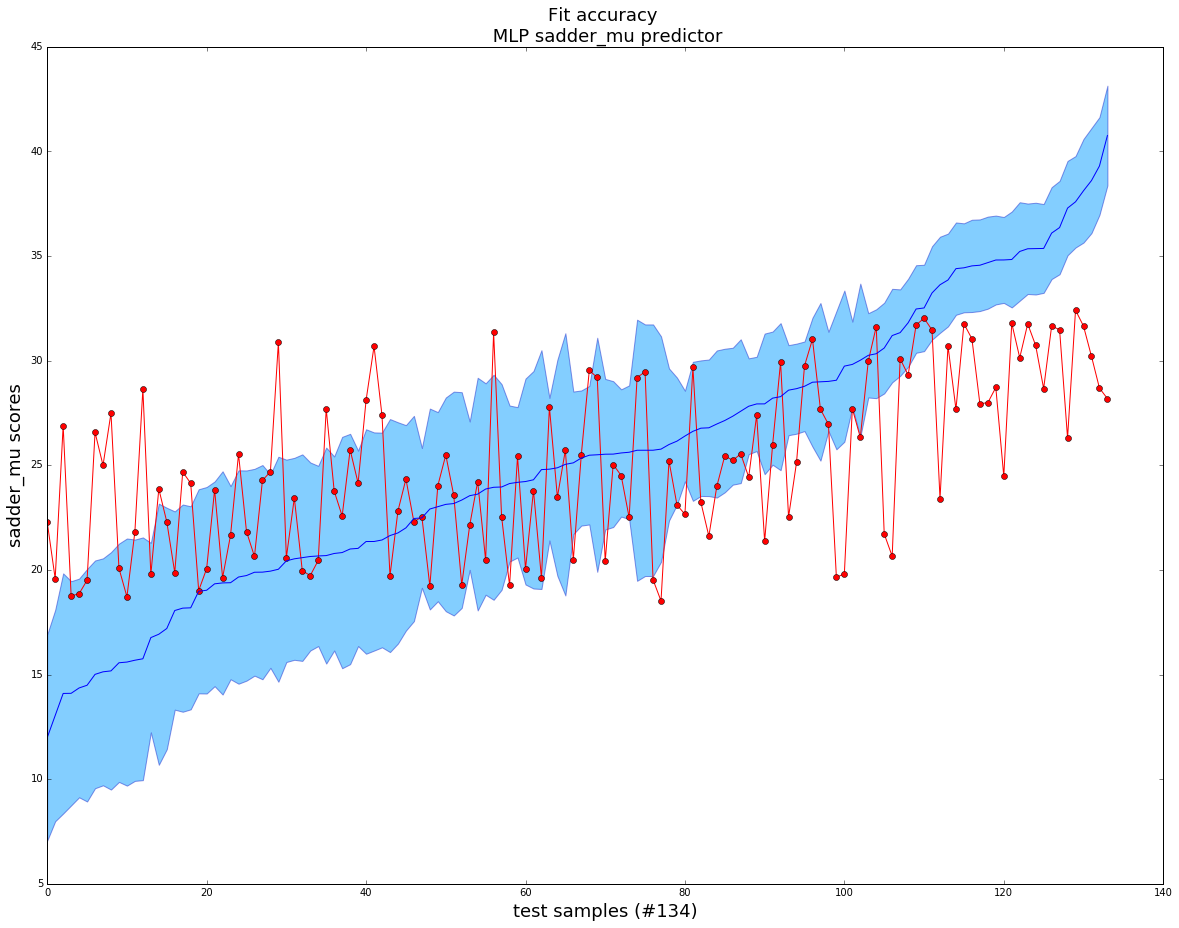

In [35]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testregr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testregr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testregr_sorted[LABEL].values-y_all_testregr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testregr_sorted[LABEL].values+y_all_testregr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n MLP ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

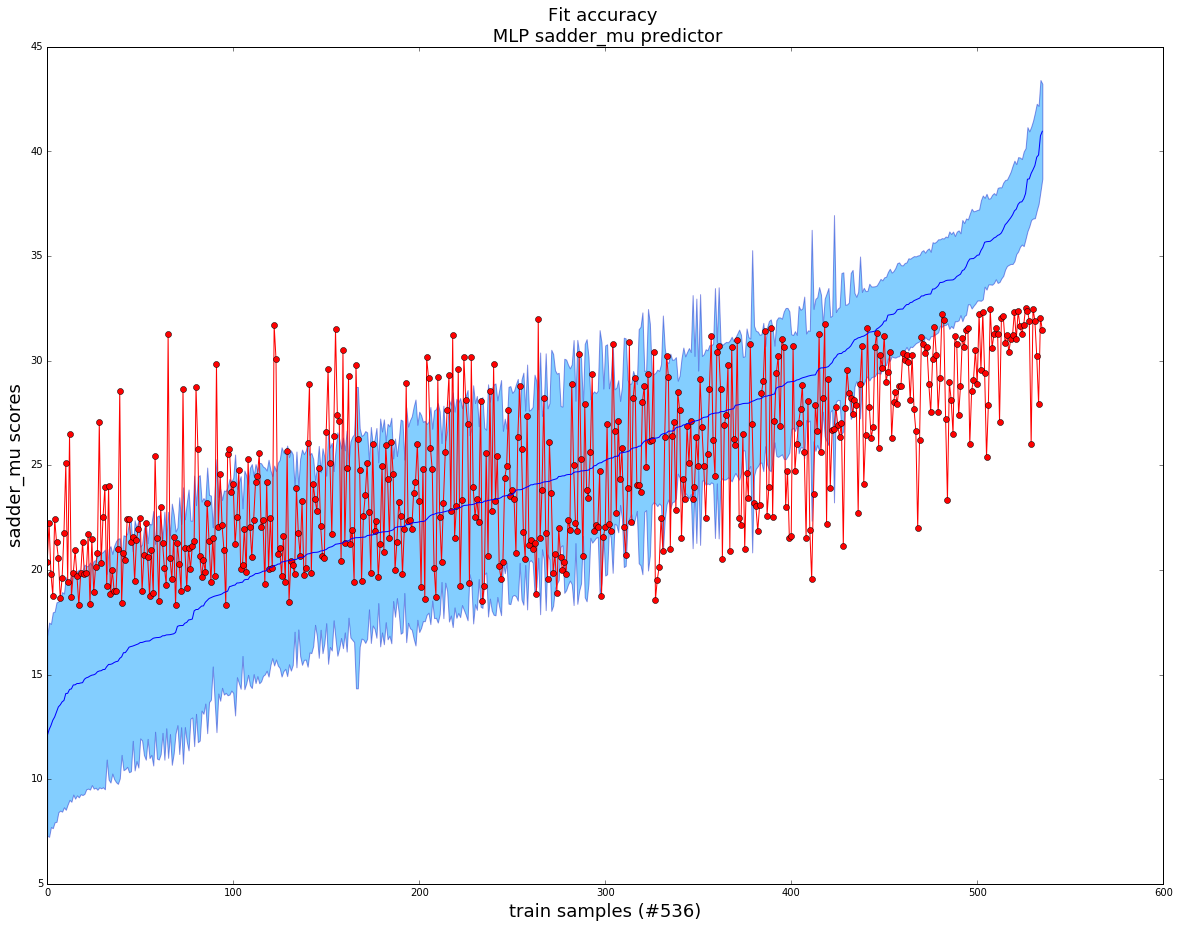

In [36]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainregr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_trainregr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainregr_sorted[LABEL].values-y_all_trainregr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainregr_sorted[LABEL].values+y_all_trainregr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n MLP ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

Populating the interactive namespace from numpy and matplotlib


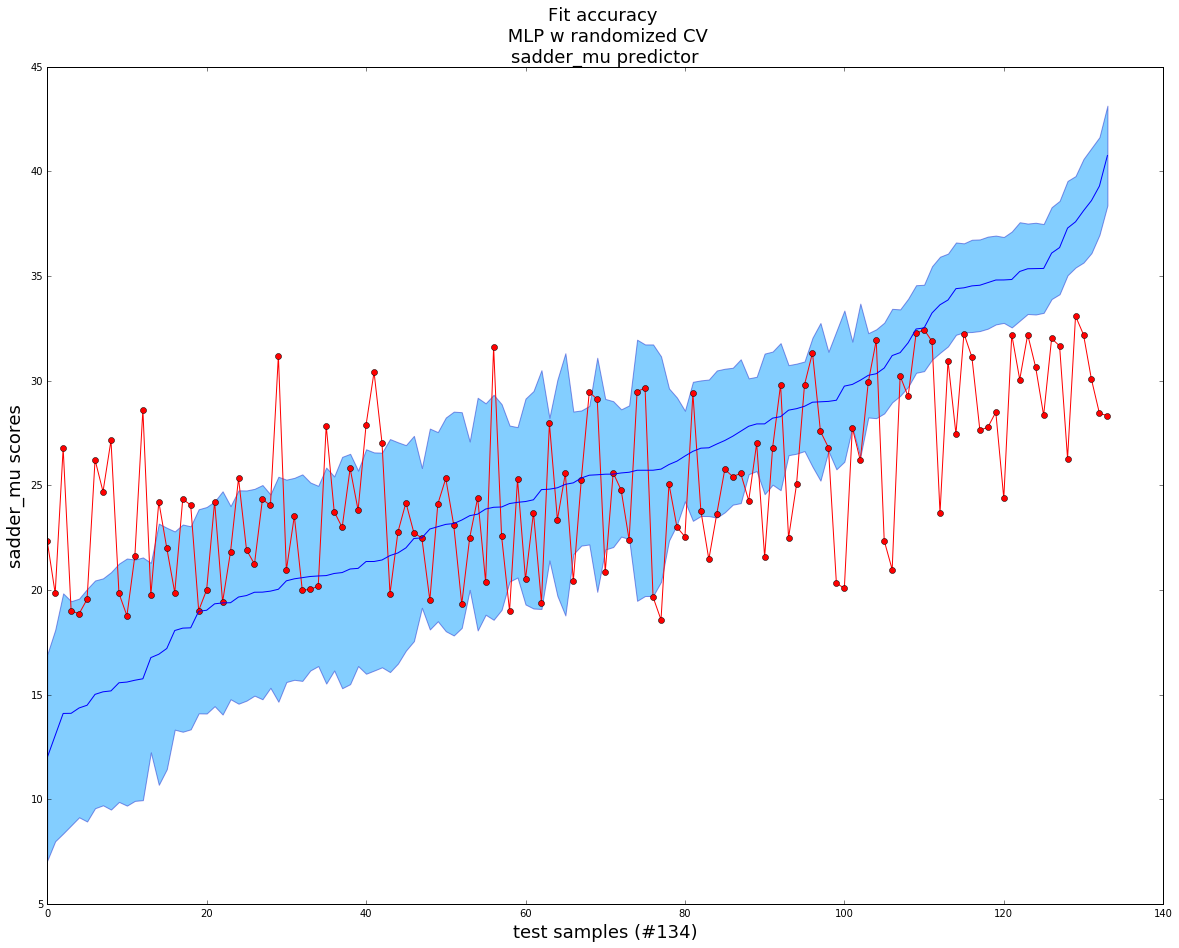

In [37]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testregr_randcv_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testregr_randcv_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testregr_randcv_sorted[LABEL].values-y_all_testregr_randcv_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testregr_randcv_sorted[LABEL].values+y_all_testregr_randcv_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testregr_randcv_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n MLP w randomized CV\n' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

Populating the interactive namespace from numpy and matplotlib


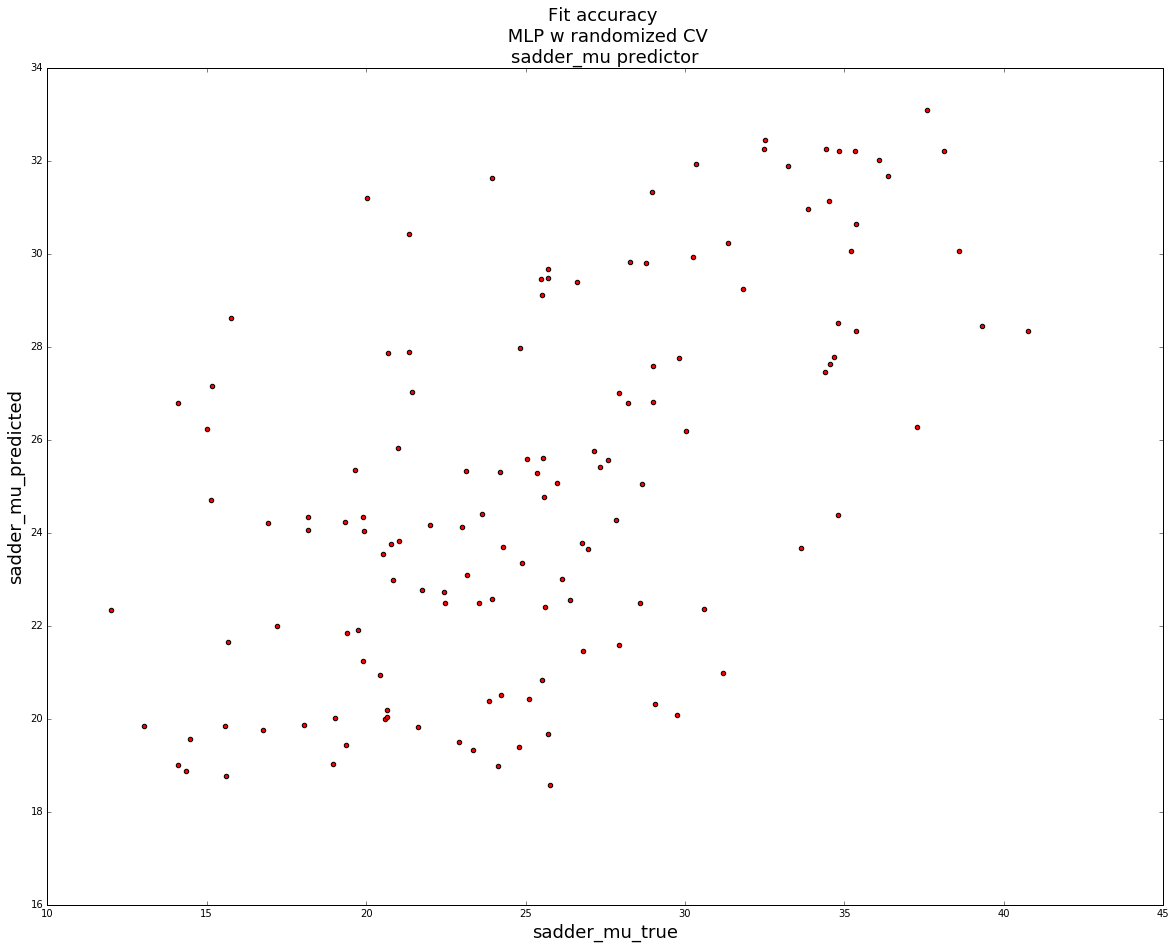

In [38]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
plt.scatter(y_all_testregr_randcv_sorted[LABEL].values,y_all_testregr_randcv_sorted[predicted_name].values, c="r",marker="o")
plt.title('Fit accuracy \n MLP w randomized CV\n' + LABEL + ' predictor',fontsize=18)
plt.xlabel(LABEL + '_true',fontsize=18)
plt.ylabel(LABEL +'_predicted',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

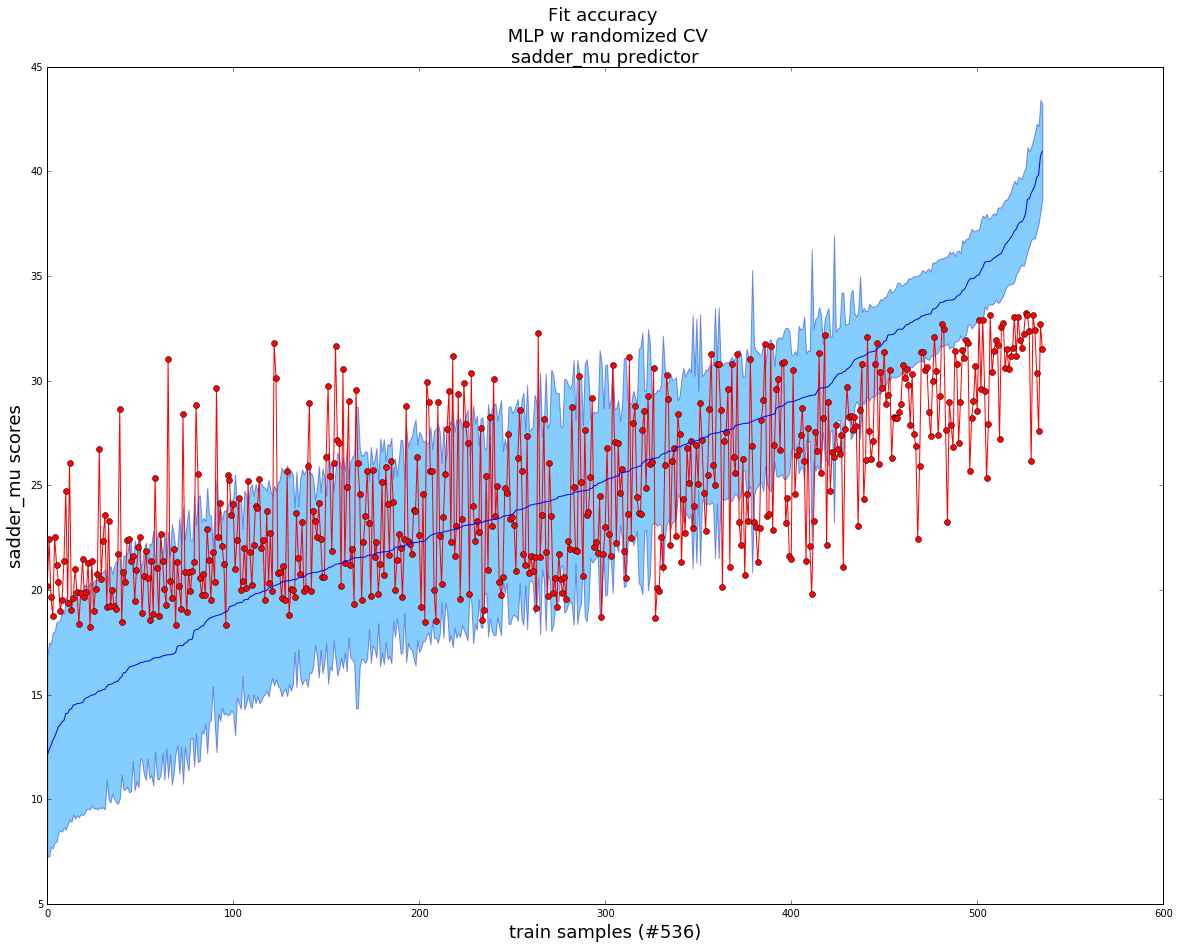

In [39]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainregr_randcv_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_trainregr_randcv_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainregr_randcv_sorted[LABEL].values-y_all_trainregr_randcv_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainregr_randcv_sorted[LABEL].values+y_all_trainregr_randcv_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainregr_randcv_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n MLP w randomized CV\n' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [40]:
y_hat_lr = pd.DataFrame(ytest_pred_lr, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testlr = pd.concat([y_hat_lr, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testlr_sorted = y_all_testlr.sort_values(EMOSCORES[emotionid],ascending=[True])

ytrain_hat_lr = pd.DataFrame(ytrain_pred_lr, columns=[predicted_name], index=y_train[LABEL].index) 

y_all_trainlr = pd.concat([ytrain_hat_lr, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_trainlr_sorted = y_all_trainlr.sort_values(EMOSCORES[emotionid],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


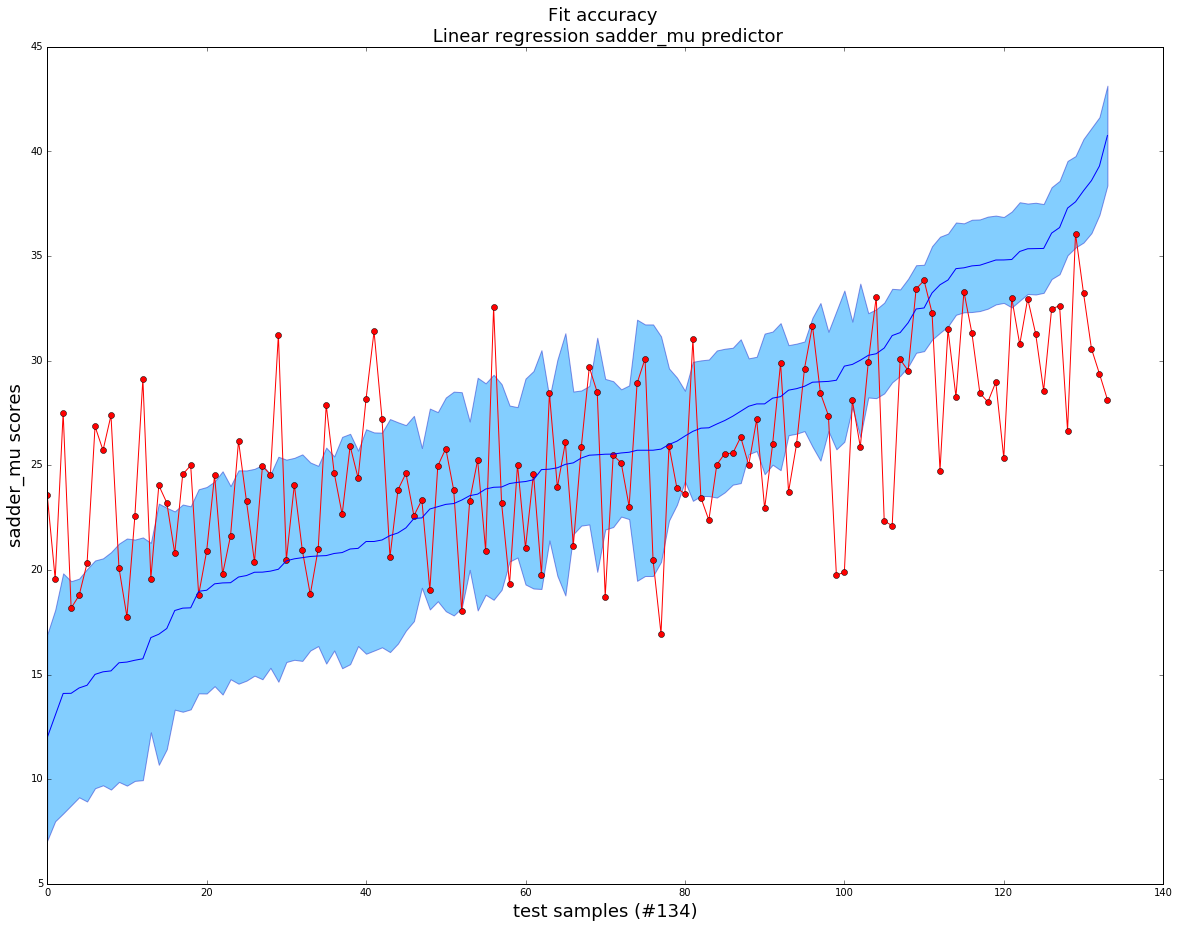

In [41]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testlr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testlr_sorted[LABEL].values-y_all_testlr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testlr_sorted[LABEL].values+y_all_testlr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testlr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

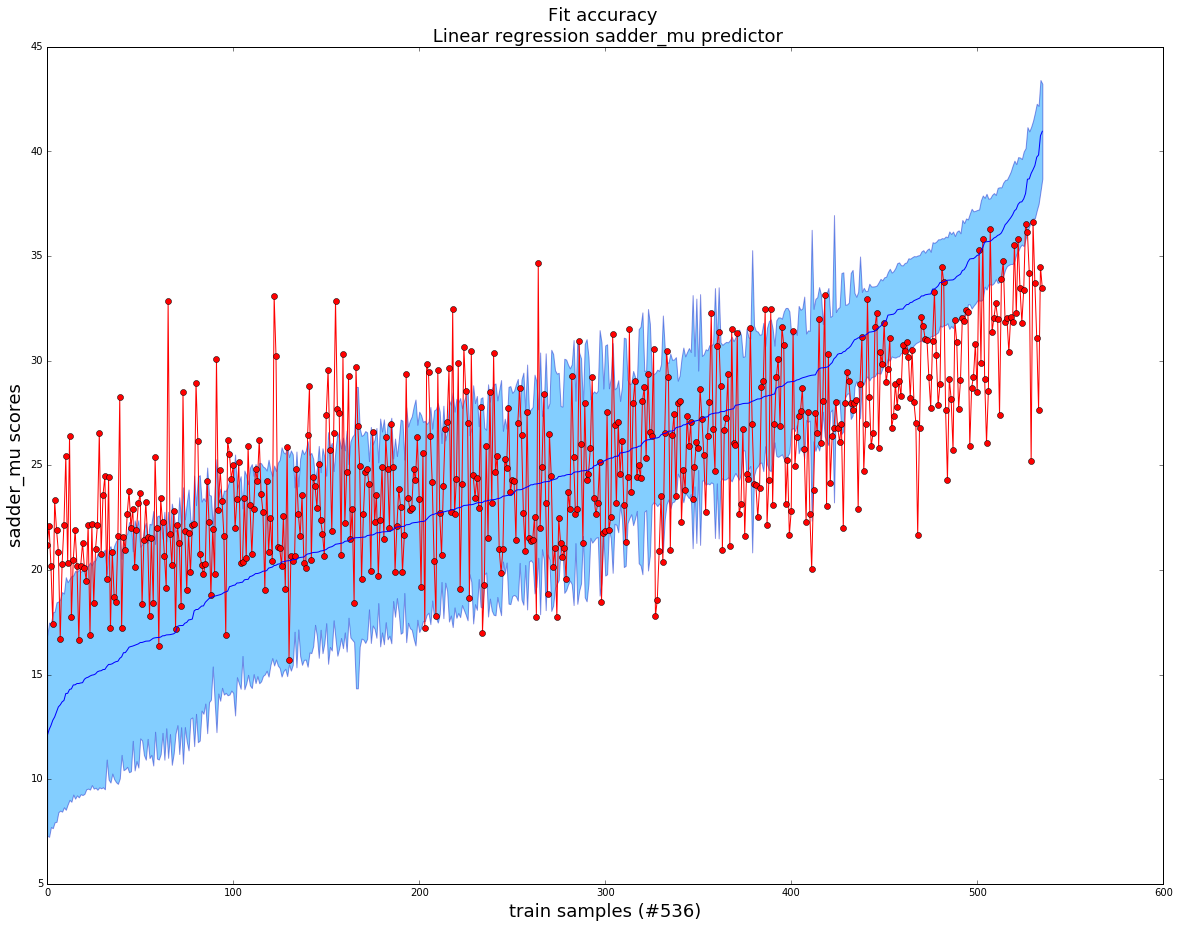

In [42]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainlr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_trainlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainlr_sorted[LABEL].values-y_all_trainlr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainlr_sorted[LABEL].values+y_all_trainlr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainlr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [43]:
bestEstimator_testmse = mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]])
bestEstimator_testr2 = r2_score( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]])

bestEstimator_trainmse = mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]])
bestEstimator_trainr2 = r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]])

save_info = pd.DataFrame()
regr_info = pd.Series(str(grid_search.best_estimator_.get_params()))

save_info['trained'] = regr_info
save_info['regressor name'] = "MLP Regressor"
save_info['test wtd mse'] = bestEstimator_testmse
save_info['test wtd r2'] = bestEstimator_testr2
save_info['train wtd mse'] = bestEstimator_trainmse
save_info['train wtd r2'] = bestEstimator_trainr2
save_info['emotion'] = "sad"

with open('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\regressorExperiments.csv', 'a') as f:
    save_info.to_csv(f, header=False, index=False)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\regressorExperiments.csv'